In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

import pyroundtrip as pyrt
print("Currently use version v%s of Roundtrip."%pyrt.__version__)

2025-07-14 12:13:09.430724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752520389.444754 2044043 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752520389.449071 2044043 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752520389.461781 2044043 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752520389.461798 2044043 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752520389.461800 2044043 computation_placer.cc:177] computation placer alr

Currently use version v2.0.1 of Roundtrip.


In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [3]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [4]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64) 
    return noisy_3d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 50
num_val = 10
num_test = 5

# Generate train set with mixed noise levels
x_train_3d = np.zeros((num_train, 64, 64,64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train_3d[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val_3d = np.zeros((num_val, 64, 64,64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val_3d[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")


Train, val, generated


In [5]:
# Generate test set with fixed noise level
x_test_3d = np.zeros((num_test, 64, 64,64))
for i in range(num_test):
    x_test_3d[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [6]:
y_test_3d = np.zeros((x_test_3d.shape[0],64,64,64))
y_train_3d = np.zeros((x_train_3d.shape[0],64,64,64))
y_val_3d = np.zeros((x_val_3d.shape[0],64,64,64))

for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)

for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
print("y generated")

y generated


In [7]:
import numpy as np

def batch_project_3d_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                            y_train_3d, y_val_3d, y_test_3d,
                            buffer_scale=1.10):
    """
    Projects all input and output 3D densities to 2D RGB with shared normalization.

    Args:
        x_train_3d, x_val_3d, x_test_3d, y_train_3d, y_val_3d, y_test_3d: ndarray of shape (N, H, W, D)
        buffer_scale: float, buffer for normalization (default 10%)

    Returns:
        Tuple of normalized RGB arrays in order:
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb
    """
    def split_sum_rgb(x_3d):
        N, H, W, D = x_3d.shape
        thirds = np.array_split(np.arange(D), 3)
        r = np.sum(x_3d[:, :, :, thirds[0]], axis=-1)
        g = np.sum(x_3d[:, :, :, thirds[1]], axis=-1)
        b = np.sum(x_3d[:, :, :, thirds[2]], axis=-1)
        return np.stack([r, g, b], axis=-1)

    # Convert all to RGB (unnormalized)
    x_train_rgb = split_sum_rgb(x_train_3d)
    x_val_rgb   = split_sum_rgb(x_val_3d)
    x_test_rgb  = split_sum_rgb(x_test_3d)
    y_train_rgb = split_sum_rgb(y_train_3d)
    y_val_rgb   = split_sum_rgb(y_val_3d)
    y_test_rgb  = split_sum_rgb(y_test_3d)

    # Compute global max
    global_max = np.max([
        x_train_rgb.max(), x_val_rgb.max(), x_test_rgb.max(),
        y_train_rgb.max(), y_val_rgb.max(), y_test_rgb.max()
    ])
    buffered_max = global_max * buffer_scale

    # Normalize all
    def normalize(x_rgb):
        return np.clip(x_rgb / buffered_max, 0, 1)

    return (
        normalize(x_train_rgb), normalize(x_val_rgb), normalize(x_test_rgb),
        normalize(y_train_rgb), normalize(y_val_rgb), normalize(y_test_rgb)
    )


In [8]:
x_train_rgb, x_val_rgb, x_test_rgb, y_train_rgb, y_val_rgb, y_test_rgb = batch_project_3d_to_rgb(
    x_train_3d, x_val_3d, x_test_3d,
    y_train_3d, y_val_3d, y_test_3d,
    buffer_scale=1.10
)




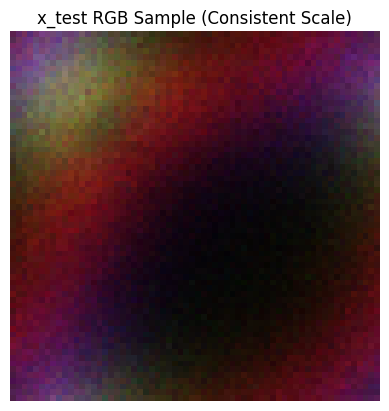

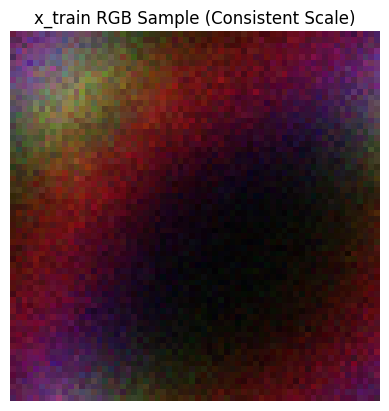

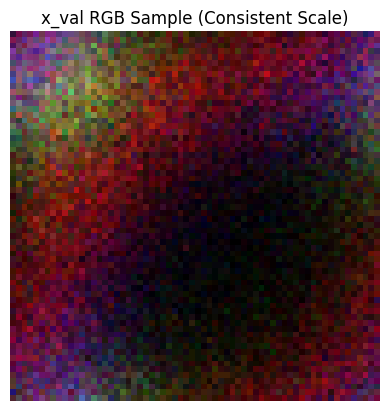

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_test_rgb[0])
plt.title("x_test RGB Sample (Consistent Scale)")
plt.axis('off')
plt.show()
plt.imshow(x_train_rgb[0])
plt.title("x_train RGB Sample (Consistent Scale)")
plt.axis('off')
plt.show()
plt.imshow(x_val_rgb[0])
plt.title("x_val RGB Sample (Consistent Scale)")
plt.axis('off')
plt.show()

In [10]:
print("here")

here


In [11]:
import os

# Get the current working directory
current_working_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_working_directory)


Current Working Directory: /global/u2/k/kberard/SCGSR/Research/EDDAE/Diamond/Testing/2D/Roundtrip


In [12]:
import yaml
params = yaml.safe_load(open('/global/u2/k/kberard/SCGSR/Research/EDDAE/Diamond/Testing/2D/Roundtrip/config/config_dm.yaml', 'r'))
print(params)

{'dataset': 'density', 'output_dir': '.', 'x_dim': 64, 'z_dim': 10, 'lr': 0.0002, 'alpha': 10, 'beta': 1, 'gamma': 0, 'g_d_freq': 1, 'g_units': [64, 32], 'e_units': [32, 64], 'dz_units': [20, 10], 'dx_units': [16, 8], 'save_model': True, 'sd_x': 0.05, 'scale': 0.5, 'sample_size': 20000}


In [13]:
model = pyrt.RoundtripTV_img(params=params,random_seed=123)


2025-07-14 12:13:26.898206: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
print(x_train_rgb.shape)

(50, 64, 64, 3)


In [15]:
model.train(data=x_train_rgb, save_format='npy', n_iter=100000, batches_per_eval=5000)

ValueError: in user code:

    File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/pyroundtrip/roundtrip.py", line 1275, in train_disc_step  *
        data_dx_ = self.dx_net(data_x_)
    File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/pyroundtrip/model.py", line 142, in call
        output = self.out_layer(x)

    ValueError: Exception encountered when calling Discriminator_img.call().
    
    [1mInput 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 2048, but received input with shape (32, 512)[0m
    
    Arguments received by Discriminator_img.call():
      • inputs=tf.Tensor(shape=(32, 32, 32, 3), dtype=float32)
      • training=True
